In [ ]:
!pip install transformers torch pandas scikit-learn seaborn textblob

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm.notebook import tqdm
import joblib
import re
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import joblib

# Google Drive Baƒülantƒ±sƒ±
drive.mount('/content/drive')

# --- Sabitler ve Ayarlar ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_MODEL_NAME = 'dbmdz/bert-base-turkish-uncased'
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 2e-5

# Veri Y√ºkleme ve √ñn ƒ∞≈üleme
try:
    data_path = "/content/drive/MyDrive/modeller/cumle_uzunlugu_veriseti.xlsx"
    df = pd.read_excel(data_path)
    df = df[['Metin', 'Etiket']].rename(columns={'Metin': 'text', 'Etiket': 'label'})
    print(f"‚úÖ Veri ba≈üarƒ±yla y√ºklendi. Toplam √∂rnek sayƒ±sƒ±: {len(df)}")
    print("‚è≥ Veri √∂nizleme:")
    print(df.head())

except Exception as e:
    print(f"‚ùå Hata: {str(e)}")
    print("‚ö†Ô∏è L√ºtfen dosya yolunu ve formatƒ±nƒ± kontrol edin.")
    df = None

# Eƒüer veri y√ºklenemediyse, programƒ±n devam etmesini engelle
if df is None:
    raise FileNotFoundError("Veri dosyasƒ± bulunamadƒ± veya y√ºklenemedi. Program sonlandƒ±rƒ±lƒ±yor.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
‚úÖ Veri ba≈üarƒ±yla y√ºklendi. Toplam √∂rnek sayƒ±sƒ±: 200
‚è≥ Veri √∂nizleme:
                                   text  label
0                   Ben‚Ä¶ ben neredeyim?      1
1                D√ºn doktora gideceƒüim.      1
2                Oƒülumun adƒ±nƒ± unuttum.      1
3          Kahvaltƒ±da ayakkabƒ±mƒ± yedim.      1
4  Kapƒ±yƒ± kilitledim mi? Kilitledim mi?      1


In [ ]:
# Geli≈ümi≈ü √ñzellik √áƒ±karƒ±m Fonksiyonlarƒ±
def extract_advanced_features(text):
    """Metinden geli≈ümi≈ü yapƒ±sal ve anlamsal √∂zellikler √ßƒ±karƒ±r."""
    try:
        blob = TextBlob(text)
        sentiment_polarity = blob.sentiment.polarity
    except Exception:
        sentiment_polarity = 0

    features = {
        'char_length': len(text),
        'word_count': len(text.split()),
        'unique_word_count': len(set(text.lower().split())),
        'avg_word_length': np.mean([len(word) for word in text.split()]) if text.split() else 0,
        'ellipsis_count': text.count('...'),
        'question_count': text.count('?'),
        'exclamation_count': text.count('!'),
        'repeat_count': len(re.findall(r'(\b\w+\b)(?=.*\b\1\b)', text.lower())),
        'sentiment_polarity': sentiment_polarity
    }
    return features

# Veri setine geli≈ümi≈ü √∂zellikleri ekleme
features_df = df['text'].apply(extract_advanced_features).apply(pd.Series)
df = pd.concat([df, features_df], axis=1)

# BERT ƒ∞√ßin Veri Seti ve Model Tanƒ±mlamasƒ±
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, n_classes, n_features):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size + n_features, n_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask, features):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = bert_output['pooler_output']

        combined_features = torch.cat((pooled_output, features), dim=1)

        output = self.drop(combined_features)
        return self.out(output)

# Eƒüitim ve Doƒürulama Fonksiyonlarƒ±
# --- Sadece bu kƒ±smƒ± g√ºncelleyin ---

# Eƒüitim ve Doƒürulama Fonksiyonlarƒ±
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Eƒüitim"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # D√ºzeltme: d['text'] bir liste olduƒüu i√ßin her bir metni ayrƒ± ayrƒ± i≈üle
        features_list = [extract_advanced_features(text) for text in d['text']]
        features_df = pd.DataFrame(features_list)
        features = torch.tensor(features_df.values, dtype=torch.float32).to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            features=features
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Doƒürulama"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # D√ºzeltme: d['text'] bir liste olduƒüu i√ßin her bir metni ayrƒ± ayrƒ± i≈üle
            features_list = [extract_advanced_features(text) for text in d['text']]
            features_df = pd.DataFrame(features_list)
            features = torch.tensor(features_df.values, dtype=torch.float32).to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features=features
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

‚è≥ Kaydedilmi≈ü model bulunamadƒ±, yeni model eƒüitiliyor...
Hata: [Errno 2] No such file or directory: '/content/drive/MyDrive/modeller/bert_alzheimer_model.bin'
Epoch 1/5


Eƒüitim:   0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.6341 accuracy 0.6049


Doƒürulama:   0%|          | 0/1 [00:00<?, ?it/s]

Val   loss 0.3540 accuracy 1.0000
Epoch 2/5


Eƒüitim:   0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.2546 accuracy 0.9568


Doƒürulama:   0%|          | 0/1 [00:00<?, ?it/s]

Val   loss 0.0566 accuracy 1.0000
Epoch 3/5


Eƒüitim:   0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.0483 accuracy 1.0000


Doƒürulama:   0%|          | 0/1 [00:00<?, ?it/s]

Val   loss 0.0044 accuracy 1.0000
Epoch 4/5


Eƒüitim:   0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.0109 accuracy 0.9938


Doƒürulama:   0%|          | 0/1 [00:00<?, ?it/s]

Val   loss 0.0013 accuracy 1.0000
Epoch 5/5


Eƒüitim:   0%|          | 0/11 [00:00<?, ?it/s]

Train loss 0.0015 accuracy 1.0000


Doƒürulama:   0%|          | 0/1 [00:00<?, ?it/s]

Val   loss 0.0006 accuracy 1.0000
‚úÖ BERT modeli ba≈üarƒ±yla eƒüitildi ve kaydedildi.


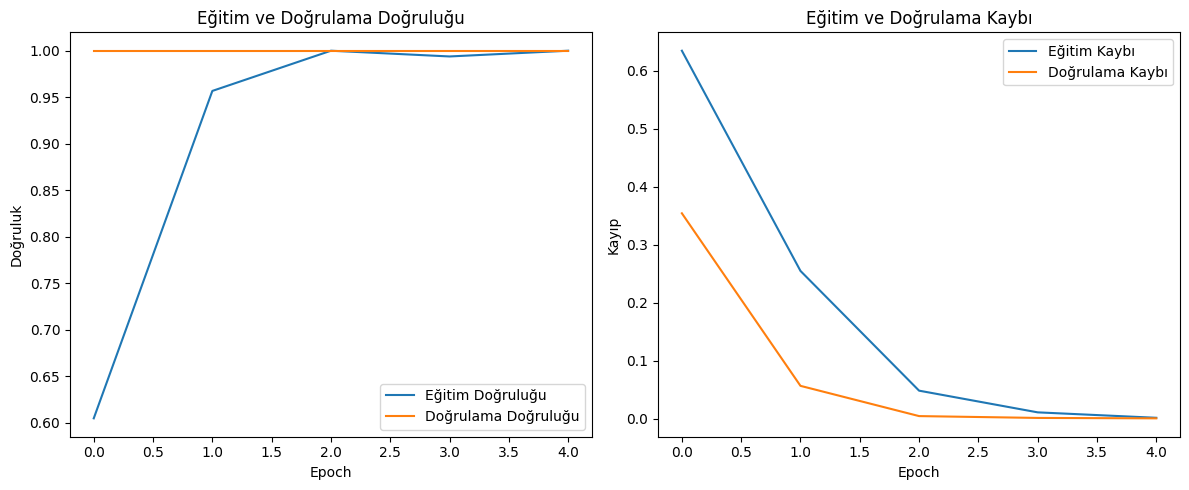

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/modeller/bert_alzheimer_model.bin'
TOKENIZER_SAVE_PATH = '/content/drive/MyDrive/modeller/bert_alzheimer_tokenizer.bin'

def load_or_train_bert_model(df):
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    n_features = len(extract_advanced_features("sample text"))
    model = BertClassifier(BERT_MODEL_NAME, n_classes=2, n_features=n_features)
    model = model.to(DEVICE)

    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        tokenizer = joblib.load(TOKENIZER_SAVE_PATH)
        print("‚úÖ BERT modeli ba≈üarƒ±yla y√ºklendi.")
        return model, tokenizer
    except (FileNotFoundError, RuntimeError) as e:
        print("‚è≥ Kaydedilmi≈ü model bulunamadƒ±, yeni model eƒüitiliyor...")
        print(f"Hata: {e}")

        df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])
        df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train['label'])

        train_dataset = BertDataset(
            texts=df_train.text.to_numpy(),
            labels=df_train.label.to_numpy(),
            tokenizer=tokenizer,
            max_len=MAX_LEN
        )
        val_dataset = BertDataset(
            texts=df_val.text.to_numpy(),
            labels=df_val.label.to_numpy(),
            tokenizer=tokenizer,
            max_len=MAX_LEN
        )

        train_data_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
        val_data_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE)

        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.CrossEntropyLoss().to(DEVICE)

        history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

        for epoch in range(EPOCHS):
            print(f"Epoch {epoch + 1}/{EPOCHS}")
            train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, DEVICE, len(df_train))
            print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")
            val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, DEVICE, len(df_val))
            print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")

            history['train_acc'].append(train_acc.item())
            history['train_loss'].append(train_loss)
            history['val_acc'].append(val_acc.item())
            history['val_loss'].append(val_loss)

        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        joblib.dump(tokenizer, TOKENIZER_SAVE_PATH)
        print("‚úÖ BERT modeli ba≈üarƒ±yla eƒüitildi ve kaydedildi.")

        # Eƒüitim ve doƒürulama performansƒ± grafikleri
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_acc'], label='Eƒüitim Doƒüruluƒüu')
        plt.plot(history['val_acc'], label='Doƒürulama Doƒüruluƒüu')
        plt.title('Eƒüitim ve Doƒürulama Doƒüruluƒüu')
        plt.xlabel('Epoch')
        plt.ylabel('Doƒüruluk')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['train_loss'], label='Eƒüitim Kaybƒ±')
        plt.plot(history['val_loss'], label='Doƒürulama Kaybƒ±')
        plt.title('Eƒüitim ve Doƒürulama Kaybƒ±')
        plt.xlabel('Epoch')
        plt.ylabel('Kayƒ±p')
        plt.legend()
        plt.tight_layout()
        plt.show()

        return model, tokenizer

# Modeli y√ºkle veya eƒüit
model, tokenizer = load_or_train_bert_model(df)


üß† Geli≈ümi≈ü Alzheimer C√ºmle Risk Analiz Sistemi (BERT)
üìù √áƒ±kmak i√ßin 'q' girin

üîç Analiz etmek istediƒüiniz c√ºmleyi girin: merhaba d√ºnya

üî¨ Analiz Sonu√ßlarƒ±:
üìä Risk Olasƒ±lƒ±ƒüƒ±: 0.996
üè∑Ô∏è Sƒ±nƒ±f: RISKLƒ∞ (1)


/tmp/ipython-input-4104393163.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Rƒ∞SKSƒ∞Z', 'Rƒ∞SKLƒ∞'], y=probabilities, palette=['green', 'red'])


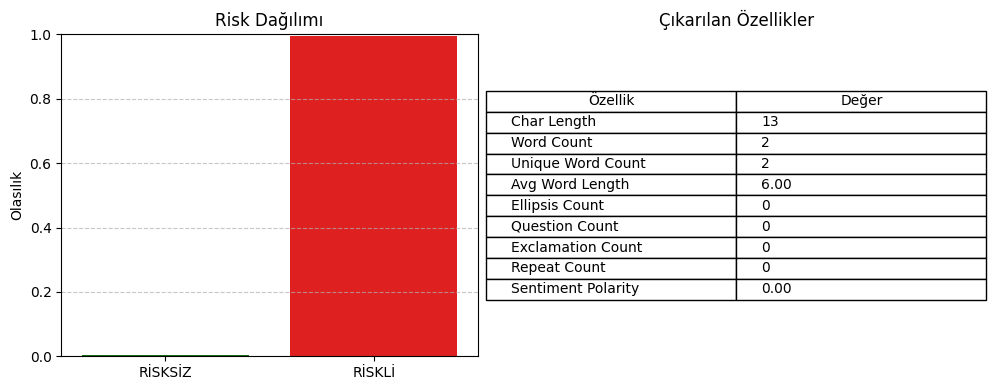

KeyboardInterrupt: Interrupted by user

In [ ]:
def analyze_text_with_bert():
    print("\n" + "="*50)
    print("üß† Geli≈ümi≈ü Alzheimer C√ºmle Risk Analiz Sistemi (BERT)")
    print("="*50)
    print("üìù √áƒ±kmak i√ßin 'q' girin\n")

    model.eval()

    while True:
        user_input = input("üîç Analiz etmek istediƒüiniz c√ºmleyi girin: ")

        if user_input.lower() == 'q':
            print("üëã √áƒ±kƒ±≈ü yapƒ±lƒ±yor...")
            break

        if len(user_input.strip()) < 5:
            print("‚ö†Ô∏è L√ºtfen daha uzun bir c√ºmle girin (min 5 karakter).")
            continue

        # √ñzellik √ßƒ±karƒ±mƒ± ve √∂n i≈üleme
        features_dict = extract_advanced_features(user_input)
        features_list = list(features_dict.values())
        features_tensor = torch.tensor([features_list], dtype=torch.float32).to(DEVICE)

        encoding = tokenizer.encode_plus(
            user_input,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(DEVICE)
        attention_mask = encoding['attention_mask'].to(DEVICE)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                features=features_tensor
            )

        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]
        risk_probability = probabilities[1]
        risk_class = 1 if risk_probability >= 0.5 else 0

        # Sonu√ßlarƒ± g√∂sterme
        print("\nüî¨ Analiz Sonu√ßlarƒ±:")
        print(f"üìä Risk Olasƒ±lƒ±ƒüƒ±: {risk_probability:.3f}")
        print(f"üè∑Ô∏è Sƒ±nƒ±f: {'RISKLƒ∞ (1)' if risk_class == 1 else 'Rƒ∞SKSƒ∞Z (0)'}")

        # G√∂rselle≈ütirme
        plt.figure(figsize=(10, 4))

        # Bar chart
        plt.subplot(1, 2, 1)
        sns.barplot(x=['Rƒ∞SKSƒ∞Z', 'Rƒ∞SKLƒ∞'], y=probabilities, palette=['green', 'red'])
        plt.title('Risk Daƒüƒ±lƒ±mƒ±')
        plt.ylabel('Olasƒ±lƒ±k')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # √ñzellik deƒüerleri tablosu
        plt.subplot(1, 2, 2)
        plt.axis('off')
        table_data = [[key.replace('_', ' ').title(), f"{value:.2f}" if isinstance(value, float) else value] for key, value in features_dict.items()]
        table = plt.table(cellText=table_data, colLabels=["√ñzellik", "Deƒüer"], loc='center', cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        plt.title("√áƒ±karƒ±lan √ñzellikler", fontsize=12)

        plt.tight_layout()
        plt.show()

# Analiz sistemini ba≈ülat
analyze_text_with_bert()